In [ ]:
# default_exp detect_tensorflow

# detect

> Pose Detector class based on Open PifPaf and some pose modification tools

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
#%pip install tensorflow
#%pip install tensorflow-hub
#%pip install opencv-python
#%pip install git+https://github.com/tensorflow/docs
#%pip install tensorflow-io
#%pip install imageio

#%pip install wget
#import wget
#wget.download("https://tfhub.dev/google/movenet/singlepose/thunder/4?tf-hub-format=compressed")
#!tar -zxf movenet_singlepose_thunder_4.tar.gz --directory movenet_singlepose_thunder_4

In [ ]:
#export
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow_docs.vis import embed
import numpy as np
import cv2

from PIL import Image
import os

from pathlib import Path

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

# See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb
# Also https://www.tensorflow.org/hub/tutorials/movenet

class Detector:
    """Given a still image (or video frame), finds poses.
    
    Attributes:  
        module: The pose detection module to load from TFHub
        input_sie: The input resolution of the model
    """
    
    def __init__(self):
        self.input_size = 256
        
    def init_model(self):
        if not Path("movenet_singlepose_thunder_4").exists():
            self.module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        else:
            self.module = tf.saved_model.load("movenet_singlepose_thunder_4")

    # Dictionary that maps from joint names to keypoint indices.
    KEYPOINT_DICT = {
        'nose': 0,
        'left_eye': 1,
        'right_eye': 2,
        'left_ear': 3,
        'right_ear': 4,
        'left_shoulder': 5,
        'right_shoulder': 6,
        'left_elbow': 7,
        'right_elbow': 8,
        'left_wrist': 9,
        'right_wrist': 10,
        'left_hip': 11,
        'right_hip': 12,
        'left_knee': 13,
        'right_knee': 14,
        'left_ankle': 15,
        'right_ankle': 16
    }

    # Maps bones to a matplotlib color name.
    KEYPOINT_EDGE_INDS_TO_COLOR = {
        (0, 1): 'm',
        (0, 2): 'c',
        (1, 3): 'm',
        (2, 4): 'c',
        (0, 5): 'm',
        (0, 6): 'c',
        (5, 7): 'm',
        (7, 9): 'm',
        (6, 8): 'c',
        (8, 10): 'c',
        (5, 6): 'y',
        (5, 11): 'm',
        (6, 12): 'c',
        (11, 12): 'y',
        (11, 13): 'm',
        (13, 15): 'm',
        (12, 14): 'c',
        (14, 16): 'c'
    }

    # Confidence score to determine whether a keypoint prediction is reliable.
    MIN_CROP_KEYPOINT_SCORE = 0.2

    def __keypoints_and_edges_for_display__(self, keypoints_with_scores, height, width, height_crop_ratio=1.0, width_crop_ratio=1.0, height_offset=0, width_offset=0, keypoint_threshold=0.11):
        """Returns high confidence keypoints and edges for visualization.

        Args:
          keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
            the keypoint coordinates and scores returned from the MoveNet model.
          height: height of the image in pixels.
          width: width of the image in pixels.
          height_crop_ratio: If the height of the display overlay image is different
            from the version of the image used as input to the pose detection model,
            this is used to scale the keypoint positions (in concert with the
            height_offset parameter -- see below) so that they appear over the
            appropriate positions on the display image.
          width_crop_ratio: See height_crop_ratio above.
          height_offset: If the height of the display overlay image is different from
            the version of the image used as input to the pose detection model, this
            is used to shift the keypoint positions (in concert with the
            height_crop_ratio parameter -- see above) so that they appear over the
            appropriate positions on the display image.
          width_offset: See height_offset above.
          keypoint_threshold: minimum confidence score for a keypoint to be
            visualized.

        Returns:
          A (keypoints_xy, edges_xy, edge_colors) containing:
            * the coordinates of all keypoints of all detected entities;
            * the coordinates of all skeleton edges of all detected entities;
            * the colors in which the edges should be plotted.
        """
        keypoints_all = []
        keypoint_edges_all = []
        edge_colors = []
        num_instances, _, _, _ = keypoints_with_scores.shape
        for idx in range(num_instances):
            kpts_x = keypoints_with_scores[0, idx, :, 1]
            kpts_y = keypoints_with_scores[0, idx, :, 0]
            kpts_scores = keypoints_with_scores[0, idx, :, 2]
            kpts_absolute_xy = np.stack(
                [(width * np.array(kpts_x) * width_crop_ratio) + width_offset, (height * np.array(kpts_y) * height_crop_ratio) - height_offset], axis=-1)
            kpts_above_thresh_absolute = kpts_absolute_xy[
                kpts_scores > keypoint_threshold, :]
            keypoints_all.append(kpts_above_thresh_absolute)

            for edge_pair, color in self.KEYPOINT_EDGE_INDS_TO_COLOR.items():
                if (kpts_scores[edge_pair[0]] > keypoint_threshold and kpts_scores[edge_pair[1]] > keypoint_threshold):
                    x_start = kpts_absolute_xy[edge_pair[0], 0]
                    y_start = kpts_absolute_xy[edge_pair[0], 1]
                    x_end = kpts_absolute_xy[edge_pair[1], 0]
                    y_end = kpts_absolute_xy[edge_pair[1], 1]
                    line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                    keypoint_edges_all.append(line_seg)
                    edge_colors.append(color)
        if keypoints_all:
            keypoints_xy = np.concatenate(keypoints_all, axis=0)
        else:
            keypoints_xy = np.zeros((0, 17, 2))

        if keypoint_edges_all:
            edges_xy = np.stack(keypoint_edges_all, axis=0)
        else:
            edges_xy = np.zeros((0, 2, 2))
        return keypoints_xy, edges_xy, edge_colors
    
    def draw_prediction_on_image(self, image, keypoint_scores_array, blank_background=False):
        
        im = self.__decode_image__(image).numpy()
        
        image_height, image_width, _ = im.shape
        
        unitized_keypoint_scores = np.copy(keypoint_scores_array)
        
        for idx in range(17):
            unitized_keypoint_scores[idx, 0] = keypoint_scores_array[idx, 0] / image_height
            unitized_keypoint_scores[idx, 1] = keypoint_scores_array[idx, 1] / image_width
        
        return self.__draw_prediction_on_image__(im, unitized_keypoint_scores, blank_background=blank_background)

    def __draw_prediction_on_image__(self, image, keypoint_scores_array, crop_region=None, output_image_height=None, output_image_width=None, blank_background=False):
        """Draws the keypoint predictions on image.

        Args:
            image: A numpy array with shape [height, width, channel] representing the
            pixel values of the input image.
            keypoint_scores_array: A numpy array with shape [17, 3] representing
            the keypoint coordinates and scores returned from the MoveNet model.
            crop_region: A dictionary that defines the coordinates of the bounding box
            of the crop region in normalized coordinates (see the init_crop_region
            function below for more detail). If provided, this function will also
            draw the bounding box on the image.
            output_image_height: The height in pixels of the output image. If specified,
            the image will be cropped to fit the desired output height and width, with
            the positions of the visualized keypoints adjusted as necessary.
            output_image_width: The width in pexels of the output image. If this is not
            specified but output_image_height is, its value will be inferred to
            conform with the aspect ratio of the input image (see output_image_height).

        Returns:
            A numpy array with shape [out_height, out_width, channel] representing the
            image overlaid with keypoint predictions.
        """
        height, width, _ = image.shape
        aspect_ratio = float(width) / height

        height_crop_ratio = 1
        width_crop_ratio = 1
        height_offset = 0
        width_offset = 0
        
        keypoints_with_scores = tf.expand_dims(tf.expand_dims(keypoint_scores_array, axis=0), axis=0)

        if output_image_height is not None:
            if output_image_width is None:
                output_image_width = int(output_image_height * aspect_ratio)

            height_offset = int(height / 2) - int(output_image_height / 2)
            width_offset = int(width / 2) - int(output_image_width / 2)

            height_crop_ratio = float(height) / output_image_height
            width_crop_ratio = float(width) / output_image_width

            crop_y = max(0, height_offset)
            crop_x = max(0, width_offset)

            #output_image_width = int(output_image_height / height * width)
            # image_from_plot = cv2.resize(
            #     image_from_plot, dsize=(output_image_width, output_image_height),
            #     interpolation=cv2.INTER_CUBIC)
            image = image[crop_y:min(height, crop_y+output_image_height), crop_x:min(width, crop_x+output_image_width)]
            height, width, _ = image.shape
            aspect_ratio = float(width) / height  

        fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
        # To remove the huge white borders
        fig.tight_layout(pad=0)
        ax.margins(0)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.axis('off')

        if blank_background:
            image = np.zeros([height,width,3],dtype=np.uint8)
            image.fill(255)

        im = ax.imshow(image)
        line_segments = LineCollection([], linewidths=(4), linestyle='solid')
        ax.add_collection(line_segments)
        # Turn off tick labels
        scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

        (keypoint_locs, keypoint_edges,
        edge_colors) = self.__keypoints_and_edges_for_display__(
            keypoints_with_scores, height, width, height_crop_ratio, width_crop_ratio, height_offset, width_offset)

        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
        if keypoint_edges.shape[0]:
            line_segments.set_segments(keypoint_edges)
            line_segments.set_color(edge_colors)
        if keypoint_locs.shape[0]:
            scat.set_offsets(keypoint_locs)

        if crop_region is not None:
            xmin = max(crop_region['x_min'] * width, 0.0)
            ymin = max(crop_region['y_min'] * height, 0.0)
            rec_width = min(crop_region['x_max'], 0.99) * width - xmin
            rec_height = min(crop_region['y_max'], 0.99) * height - ymin
            rect = patches.Rectangle(
                (xmin,ymin),rec_width,rec_height,
                linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)

        return image_from_plot

    def __to_gif__(self, images, fps):
        """Converts image sequence (4D numpy array) to gif."""
        imageio.mimsave('./animation.gif', images, fps=fps)
        return embed.embed_file('./animation.gif')
    
    def gif_from_detections(self, pose_output, fps=25, blank_background=False):
        output_images = []
        bar = display(self.__progress__(0, len(pose_output)-1), display_id=True)
        for frameno, frame_data in enumerate(pose_output):
            bar.update(self.__progress__(frameno, len(pose_output)-1))
            output_images.append(teddy.draw_prediction_on_image(frame_data['image'], frame_data['figures'][0], blank_background=blank_background))
        output = np.stack(output_images, axis=0)
        teddy.__to_gif__(output, fps=fps)

    def __progress__(self, value, max=100):
        return HTML("""
            <progress
                value='{value}'
                max='{max}',
                style='width: 100%'
            >
                {value}
            </progress>
        """.format(value=value, max=max))

    def __init_crop_region__(self, image_height, image_width):
        """Defines the default crop region.

        The function provides the initial crop region (pads the full image from both
        sides to make it a square image) when the algorithm cannot reliably determine
        the crop region from the previous frame.
        """
        if image_width > image_height:
            box_height = image_width / image_height
            box_width = 1.0
            y_min = (image_height / 2 - image_width / 2) / image_height
            x_min = 0.0
        else:
            box_height = 1.0
            box_width = image_height / image_width
            y_min = 0.0
            x_min = (image_width / 2 - image_height / 2) / image_width

        return {
            'y_min': y_min,
            'x_min': x_min,
            'y_max': y_min + box_height,
            'x_max': x_min + box_width,
            'height': box_height,
            'width': box_width
        }

    def __torso_visible__(self, keypoints):
        """Checks whether there are enough torso keypoints.

        This function checks whether the model is confident at predicting one of the
        shoulders/hips which is required to determine a good crop region.
        """
        return ((keypoints[0, 0, self.KEYPOINT_DICT['left_hip'], 2] >
                self.MIN_CROP_KEYPOINT_SCORE or
                keypoints[0, 0, self.KEYPOINT_DICT['right_hip'], 2] >
                self.MIN_CROP_KEYPOINT_SCORE) and
                (keypoints[0, 0, self.KEYPOINT_DICT['left_shoulder'], 2] >
                self.MIN_CROP_KEYPOINT_SCORE or
                keypoints[0, 0, self.KEYPOINT_DICT['right_shoulder'], 2] >
                self.MIN_CROP_KEYPOINT_SCORE))

    def __determine_torso_and_body_range__(self, keypoints, target_keypoints, center_y, center_x):
        """Calculates the maximum distance from each keypoints to the center location.

        The function returns the maximum distances from the two sets of keypoints:
        full 17 keypoints and 4 torso keypoints. The returned information will be
        used to determine the crop size. See determineCropRegion for more detail.
        """
        torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
        max_torso_yrange = 0.0
        max_torso_xrange = 0.0
        for joint in torso_joints:
            dist_y = abs(center_y - target_keypoints[joint][0])
            dist_x = abs(center_x - target_keypoints[joint][1])
            if dist_y > max_torso_yrange:
                max_torso_yrange = dist_y
            if dist_x > max_torso_xrange:
                max_torso_xrange = dist_x

        max_body_yrange = 0.0
        max_body_xrange = 0.0
        for joint in self.KEYPOINT_DICT.keys():
            if keypoints[0, 0, self.KEYPOINT_DICT[joint], 2] < self.MIN_CROP_KEYPOINT_SCORE:
                continue
            dist_y = abs(center_y - target_keypoints[joint][0]);
            dist_x = abs(center_x - target_keypoints[joint][1]);
            if dist_y > max_body_yrange:
                max_body_yrange = dist_y

            if dist_x > max_body_xrange:
                max_body_xrange = dist_x

        return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

    def __determine_crop_region__(self, keypoints, image_height, image_width):
        """Determines the region to crop the image for the model to run inference on.

        The algorithm uses the detected joints from the previous frame to estimate
        the square region that encloses the full body of the target person and
        centers at the midpoint of two hip joints. The crop size is determined by
        the distances between each joints and the center point.
        When the model is not confident with the four torso joint predictions, the
        function returns a default crop which is the full image padded to square.
        """
        target_keypoints = {}
        for joint in self.KEYPOINT_DICT.keys():
            target_keypoints[joint] = [
            keypoints[0, 0, self.KEYPOINT_DICT[joint], 0] * image_height,
            keypoints[0, 0, self.KEYPOINT_DICT[joint], 1] * image_width
            ]

        if self.__torso_visible__(keypoints):
            center_y = (target_keypoints['left_hip'][0] +
                        target_keypoints['right_hip'][0]) / 2;
            center_x = (target_keypoints['left_hip'][1] +
                        target_keypoints['right_hip'][1]) / 2;

            (max_torso_yrange, max_torso_xrange,
            max_body_yrange, max_body_xrange) = self.__determine_torso_and_body_range__(
                keypoints, target_keypoints, center_y, center_x)

            crop_length_half = np.amax(
                [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
                max_body_yrange * 1.2, max_body_xrange * 1.2])

            tmp = np.array(
                [center_x, image_width - center_x, center_y, image_height - center_y])
            crop_length_half = np.amin(
                [crop_length_half, np.amax(tmp)]);

            crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

            if crop_length_half > max(image_width, image_height) / 2:
                return self.__init_crop_region__(image_height, image_width)
            else:
                crop_length = crop_length_half * 2;
            return {
                'y_min': crop_corner[0] / image_height,
                'x_min': crop_corner[1] / image_width,
                'y_max': (crop_corner[0] + crop_length) / image_height,
                'x_max': (crop_corner[1] + crop_length) / image_width,
                'height': (crop_corner[0] + crop_length) / image_height -
                    crop_corner[0] / image_height,
                'width': (crop_corner[1] + crop_length) / image_width -
                    crop_corner[1] / image_width
            }
        else:
            return self.__init_crop_region__(image_height, image_width)

    def __crop_and_resize__(self, image, crop_region, crop_size):
        """Crops and resize the image to prepare for the model input."""
        boxes=[[crop_region['y_min'], crop_region['x_min'],
                crop_region['y_max'], crop_region['x_max']]]
        output_image = tf.image.crop_and_resize(
            image, box_indices=[0], boxes=boxes, crop_size=crop_size)
        return output_image

    def __run_inference__(self, image, crop_region, crop_size):
        """Runs model inference on the cropped region.

        The function runs the model inference on the cropped region and updates the
        model output to the original image coordinate system.
        """
        image_height, image_width, _ = image.shape
        input_image = self.__crop_and_resize__(
            tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
        # Run model inference.
        keypoints_with_scores = self.__detect__(input_image)
        # Update the coordinates.
        for idx in range(17):
            keypoints_with_scores[0, 0, idx, 0] = (
                crop_region['y_min'] * image_height +
                crop_region['height'] * image_height *
                keypoints_with_scores[0, 0, idx, 0]) #/ image_height
            keypoints_with_scores[0, 0, idx, 1] = (
                crop_region['x_min'] * image_width +
                crop_region['width'] * image_width *
                keypoints_with_scores[0, 0, idx, 1]) #/ image_width
        return keypoints_with_scores

    def __decode_image_file__(self, image_path):
        image = tf.io.read_file(image_path)
        if Path(image_path).suffix == ".jpeg":
            return tf.image.decode_jpeg(image)
        elif Path(image_path).suffix == ".png":
            return tf.image.decode_png(image)

    def __decode_image__(self, image):
        image_tensor = tf.convert_to_tensor(image, dtype=tf.int32)
        return tfio.experimental.color.rgb_to_bgr(image_tensor)
        #return tf.io.decode_image(np.asarray(image).astype('int32'))

    def __detect__(self, input_image):
        """Runs detection on a decoded input image.

        Args:
        input_image: A [1, height, width, 3] tensor represents the input image
            pixels. Note that the height/width should already be resized and match the
            expected input resolution of the model before passing into this function.

        Returns:
        A [1, 1, 17, 3] float numpy array representing the predicted keypoint
        coordinates and scores.
        """
        model = self.module.signatures['serving_default']

        # SavedModel format expects tensor type of int32.
        input_image = tf.cast(input_image, dtype=tf.int32)
        # Run model inference.
        outputs = model(input_image)
        # Output is a [1, 1, 17, 3] tensor.
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores
    
    def __visualize_pose__(self, keypoints_with_scores):
    
        min_y = float(min(keypoints_with_scores[0, 0, :, 0]).numpy())
        max_y = float(max(keypoints_with_scores[0, 0, :, 0]).numpy())
        min_x = float(min(keypoints_with_scores[0, 0, :, 1]).numpy())
        max_x = float(max(keypoints_with_scores[0, 0, :, 1]).numpy())

        height = int(max_y - min_y + 1)
        width = int(max_x - min_x + 1)
        
        aspect_ratio = float(width) / height

        height_crop_ratio = 1
        width_crop_ratio = 1
        height_offset = min_y
        width_offset = -min_x

        fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
        # To remove the huge white borders
        fig.tight_layout(pad=0)
        ax.margins(0)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.axis('off')

        im = np.zeros([height,width,3],dtype=np.uint8)
        im.fill(255) # or img[:] = 255
        ax.imshow(im)
        line_segments = LineCollection([], linewidths=(4), linestyle='solid')
        ax.add_collection(line_segments)
        # Turn off tick labels
        scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

        (keypoint_locs, keypoint_edges,
        edge_colors) = self.__keypoints_and_edges_for_display__(
            keypoints_with_scores, 1, 1, height_crop_ratio, width_crop_ratio, height_offset, width_offset)
        
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
        if keypoint_edges.shape[0]:
            line_segments.set_segments(keypoint_edges)
            line_segments.set_color(edge_colors)
        if keypoint_locs.shape[0]:
            scat.set_offsets(keypoint_locs)

#         if crop_region is not None:
#             xmin = max(crop_region['x_min'] * width, 0.0)
#             ymin = max(crop_region['y_min'] * height, 0.0)
#             rec_width = min(crop_region['x_max'], 0.99) * width - xmin
#             rec_height = min(crop_region['y_max'], 0.99) * height - ymin
#             rect = patches.Rectangle(
#                 (xmin,ymin),rec_width,rec_height,
#                 linewidth=1,edgecolor='b',facecolor='none')
#             ax.add_patch(rect)

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,))
        #fig.show()
        #plt.close(fig)

        #return image_from_plot
    
    def __visualize_detections__(self, keypoints_with_scores, image_tensor, rescale_keypoints=False, unitize_keypoints=True):
        # Visualize the predictions on the image
        image_height, image_width, _ = image_tensor.shape
        display_image = tf.expand_dims(image_tensor, axis=0)

        visual_keypoints_with_scores = np.copy(keypoints_with_scores)
        
        if unitize_keypoints:
            # Convert back to unit positions (0-1) rather than pixel positions
            for idx in range(17):
                visual_keypoints_with_scores[0, 0, idx, 0] = keypoints_with_scores[0, 0, idx, 0] / image_height
                visual_keypoints_with_scores[0, 0, idx, 1] = keypoints_with_scores[0, 0, idx, 1] / image_width
        
        keypoint_scores_array = visual_keypoints_with_scores[0][0]
        
        if rescale_keypoints:
            max_dim = max(image_height, image_width)
            display_image = tf.cast(tf.image.resize_with_pad(
                display_image, max_dim, max_dim), dtype=tf.int32)
            output_overlay = self.__draw_prediction_on_image__(
                np.squeeze(display_image.numpy(), axis=0), keypoint_scores_array, output_image_height=image_height, output_image_width=image_width)
        else:
            output_overlay = self.__draw_prediction_on_image__(
                image_tensor.numpy(), keypoint_scores_array, output_image_height=image_height, output_image_width=image_width)

        plt.figure(figsize=(5, 5))
        plt.imshow(output_overlay)
        _ = plt.axis('off')

    def visualize_detections(self, keypoint_scores_array, image=None):
        """Visualization front end. Unlike the internal methods, this expects the image
           input to be a standard WxHx3 array, and the keypoint locations and confidence
           scores to be a Nx17x3 matrix (N=number of figures, usually 1)
        """
        
        keypoints_with_scores = tf.expand_dims(tf.expand_dims(keypoint_scores_array, axis=0), axis=0)
    
        if image is not None:
            self.__visualize_detections__(keypoints_with_scores, self.__decode_image__(image))
        else:
            self.__visualize_pose__(keypoints_with_scores)
        
    def detect_image(self, image_path, viz=False):
        image = self.__decode_image_file__(image_path)

        # Resize and pad the image to keep the aspect ratio and fit the expected size.
        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, self.input_size, self.input_size)

        # Run model inference
        keypoints_with_scores = self.__detect__(input_image)

        if viz:
            self.__visualize_detections__(keypoints_with_scores, image, rescale_keypoints=True, unitize_keypoints=False)

        return keypoints_with_scores[0]
    
    def detect_video(self, video_file, start_seconds=0.0, end_seconds=0.0, max_frames=0, seconds_to_skip=0.0, images_too=False, write_images=False, folder_name='video_folder'):
        """ Given a video file, extracts video frames as images at `seconds_to_skip` intervals,
            from `start_seconds` to `end_seconds`, and runs `__detect_one_or_more_images__()` on each.
            Returns a list of frame pose data items, which are dictionaries with the following elements:
            { 'frame_id': <the frame's position in this list (not in the entire video, if seconds_to_skip != 0)>, 
              'time': <the frame's timecode within the excerpt (not within the full video, if start_seconds != 0)>,
              'keypoints': <keypoints with scores>,
              <OPTIONAL> 'image': <a PIL image object for the frame>
            }
            `write_images`, if true, causes the extracted frame images to be written to a folder
            specified by `folder_name`, with the naming scheme `image00001.png`
        """
        
        cap = cv2.VideoCapture(video_file)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('total frames in video:',total_frames)

        video_framerate = cap.get(cv2.CAP_PROP_FPS)
        print('video FPS:',video_framerate)
        frame_duration = 1 / float(video_framerate)

        frame_count = 0.0
        frames_processed = 0
        timecode = 0.0
        skip_until = start_seconds

        crop_region = None
        pose_output = []

        if write_images:
            if not os.path.isdir(folder_name):
                os.mkdir(folder_name)
            for filename in os.listdir(folder_name):
                file_path = os.path.join(folder_name, filename)
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)

        bar = display(self.__progress__(0, total_frames-1), display_id=True)
        while cap.isOpened() and (frame_count < total_frames):
            ret_val, im = cap.read()

            timecode = frame_count * frame_duration
            frame_count += 1

            bar.update(self.__progress__(frame_count, total_frames-1))

            if (end_seconds and timecode > end_seconds) or (max_frames and frames_processed >= max_frames):
                return pose_output

            if timecode < start_seconds:
                continue

            if im is None:
                # Might want to retry here
                # print("Missed a frame, continuing...")
                # For now, we'll count a missed frame as a processed frame
                continue

            if seconds_to_skip and timecode < skip_until:
                continue
            else:
                skip_until += seconds_to_skip

            frame_id = int(round(cap.get(1)))

            image_tensor = self.__decode_image__(im)

            # Resize and pad the image to keep the aspect ratio and fit the expected size.
            display_image = tf.expand_dims(image_tensor, axis=0)
            display_image = tf.cast(tf.image.resize_with_pad(display_image, self.input_size, self.input_size), dtype=tf.int32)

            image_height, image_width, _ = image_tensor.shape

            if crop_region is None:
                crop_region = self.__init_crop_region__(image_height, image_width)

            #detections = self.__detect_one_or_more_images__([pil_image])
            keypoints_with_scores = self.__run_inference__(image_tensor, crop_region, crop_size=[self.input_size, self.input_size])
            crop_region = self.__determine_crop_region__(keypoints_with_scores, image_height, image_width)

            this_frame_data = {'frame_id': frame_count, 'time': timecode, 'figures': keypoints_with_scores[0], 'image_height': image_height, 'image_width': image_width} #, 'flipped_figures': flipped_detections, 'zeroified_figures': zeroified_detections}
            if images_too:
                #max_dim = max(image_height, image_width)
                this_frame_data['image'] = im
                #display_image = tf.expand_dims(image_tensor, axis=0)
                #display_image = tf.cast(tf.image.resize_with_pad(display_image, max_dim, max_dim), dtype=tf.int32)
                #this_frame_data['image'] = self.__draw_prediction_on_image__(np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores, output_image_height=image_height, output_image_width=image_width)
            if write_images:
                # Image doesn't necessarily come in as RGB(A)!
                rgbim = cv2.cvtColor(im, cv2.COLOR_BGR2RGBA)
                pil_image = Image.fromarray(rgbim)
                pil_image.save(os.path.join(folder_name, 'image' + str(int(frames_processed + 1)).zfill(5) + '.png'), 'PNG')

            pose_output.append(this_frame_data)
            frames_processed += 1

        return pose_output

In [ ]:
teddy = Detector()

In [ ]:
teddy.init_model()

In [ ]:
import pickle
pose_output = teddy.detect_video("../tiktok/fujicov.mp4", write_images=False, images_too=True)
pickle.dump(pose_output, open("../tiktok/pose_data/fujicov.p", "wb"))

total frames in video: 1033
video FPS: 30.0


In [ ]:
import pickle
pose_output = pickle.load(open("../tiktok/pose_data/fujicov.p", "rb"))

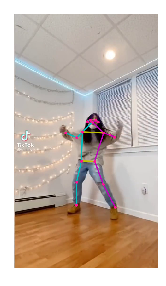

In [ ]:
teddy.visualize_detections(pose_output[50]['figures'][0], pose_output[50]['image'])

/Users/pmb/Documents/Culture/choreo/choreo_k/choreo_k/matrixify.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "data" in frame[figure_type][figure_index]: # For Open PifPaf output
/Users/pmb/Documents/Culture/choreo/choreo_k/choreo_k/matrixify.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "data" in frame[figure_type][figure_index]: # For Open PifPaf output


NameError: name 'openpipaf' is not defined

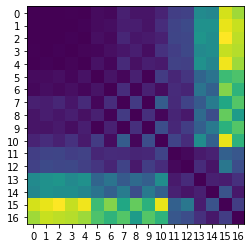

In [ ]:
from choreo_k.visualize import viz_dist_matrices
viz_dist_matrices(pose_output[50], pose_output[100], figure_type='figures')

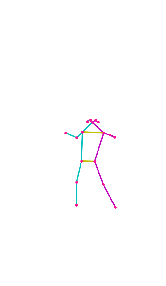

In [ ]:
image_plot = teddy.draw_prediction_on_image(pose_output[50]['image'], pose_output[50]['figures'][0], blank_background=True)
plt.figure(figsize=(5, 5))
plt.imshow(image_plot)
_ = plt.axis('off')

In [ ]:
teddy.gif_from_detections(pose_output, fps=30, blank_background=True)

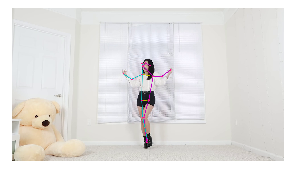

In [ ]:
#try:
#teddy = Detector()
detections = teddy.detect_image('sample_data/sample1.png', viz=True)
#print(detections[0])
#except:
#    print("Unable to instantiate a detector on your system.")

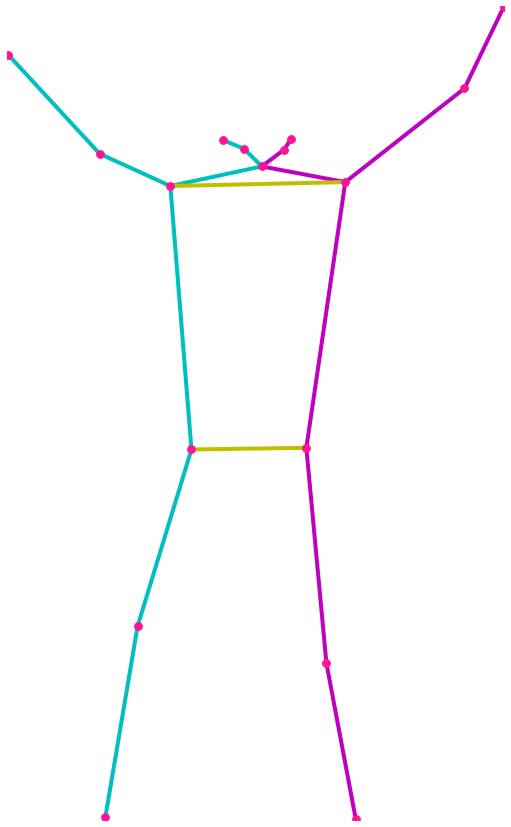

In [ ]:
teddy.visualize_detections(pose_output[59]['figures'][0])

In [ ]:
show_doc(Detector.detect_image)
show_doc(Detector.detect_video)